# Supervised Classification on Higgs and Converters Datasets

##Introduction

The goal of this analysis is to evaluate and constrast five different supervised algorithms by applying them to two classification problems:

- __Higgs Boson__: given outcomes of particle decays, detect Higgs boson; separate signal from the noise based on multitude of particle collisions created in the Atlas experiments where protons of extra-high energy are brought head-on.  

- __Converters__: given minimal user and geo information along with the converting concept, learn how to detect users who are more likely to convert after seein an impression; this probability is used for deciding when and how much to bid on the advertisment slot in realtime. 

##Data

###Higgs Dataset

The method of observing a Higgs particle is through its decay into another two tau particles. The challenge lies in the fact that these decays are small signals in the large background noise, which makes the problem very interesting for machine learning classification.

ATLAS provided a dataset with 250,000 events: a mixture of signal and background. The dataset is characterized by 30 predictor variables (features) prefixed with either:
 
 - PRI (for PRImitives) - “raw” quantities from the bunch of collisions as measured by the detector

 - DER (for DERived) - quantities computed from the primitive features, which were selected by the physicists of ATLAS
 
Additionally this training dataset includes a weights column for each event as well as labels ("s" for signal and "b" for background)

####Data Wrangling

As part of pre-analysis of the data, I have plotted all 30 features to understand their predictive power to distinguish between signal and background. 

What I have found is:

 - there is a lot of missing data in the both DER and PRI features (value = -999.0) which is considered just a noise and upon consulting ATLAS data description I have confirmed that these data values are outside of the normal range;
 
 - DER features are better at differentiating the signal as if the signal is being amplified in constrast to PRI features;
 
 - weights are not uniformly distributed which means that not all events are equally important; their probabilities will need to be accounted for during accuracy evaluation
 
Differentiating power of DERived features vs. PRImitives is demonstrated below by the example of two features only without too much of a loss of generality (the rest of the features exhibit similar behavior).

Also note the definite noise around the -999.0 level which most certainly does not include the signal.

In [1]:
%matplotlib inline
from algo_evaluation.datasets import *

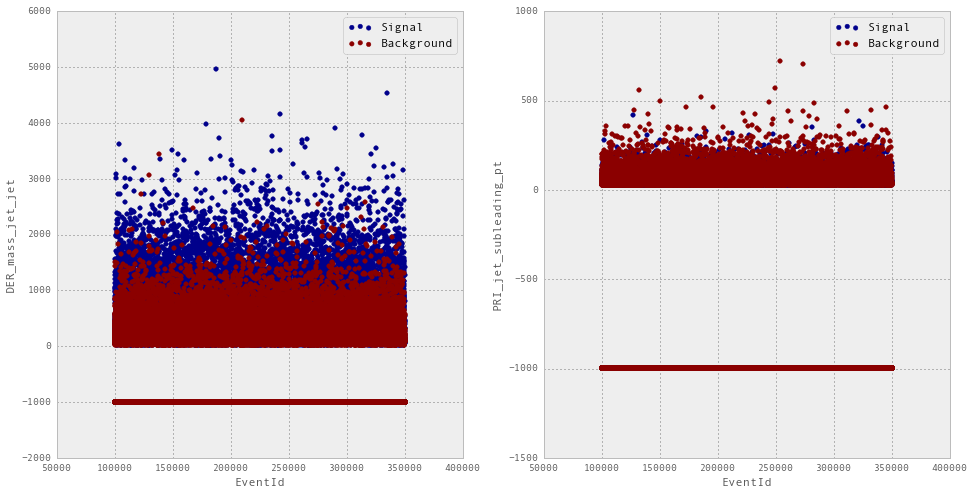

In [2]:
df = describe_higgs_raw()

As a result of the visual analysis, I made the following adjustments to the data prior to classification:

- drop data values (-999.0) as they do not contribute to the accuracy; sometimes such data is considered as missing values and is being replaced with the mean of the data however, based on my experiments, it actually hurts the accuracy;

- select only DER features for classification since PRI are already indirectly used and the signal is not so easily separable;

Higgs data and metadata after cleanup and pruning (here pruning means selecting a subset of features based on initial experiments):

In [3]:
higgs_data = load_higgs_train()
features, weights, labels = higgs_data
print 'Size of the dataset:', features.shape[0]
print 'Number of features:', features.shape[1]
print 'Number of positives (signal):', labels.value_counts()['s']
print 'Number of negatives (background):', labels.value_counts()['b']

Size of the dataset: 68114
Number of features: 13
Number of positives (signal): 31894
Number of negatives (background): 36220


#### Splitting data

Prior to running and tuning the classifier using sklearn collection of algorithms, I had split the dataset, leaving 1/3 out for evaluation purposes. (this splitting is consistent across all algorithms)

In [5]:
dataset = split_dataset(features, weights, labels)
for category in dataset:
    data = dataset[category]
    print '{}: {}'.format(category, {d: len(data[d]) for d in data})

test: {'labels': 22478, 'weights': 22478, 'features': 22478}
training: {'labels': 45636, 'weights': 45636, 'features': 45636}


###Converters Dataset

For the secondary classification problem, I have selected a converter's (Converter = online user who responds to an ad) dataset from my work group research. Dataset represents examples for one campaign of 1-4 days (based on the number of impressions (ads) shown by campaign per day)

The class variable is what we are trying to predict and can be one of the following values:

- non-converter: If this impression did not generate lead or conversion
- lead: If this impression made the user visit lead pixel (e.g. homepage, form page, etc.)
- converter: If this impression led to conversion

In contrast to real-valued features in the Higgs dataset, converters' features are mostly categorical, so in order to apply classification algorithms, I did pre-processing which transformed non-numerical features to numerical using sklearn LabelEncoding library.

Converters' data and metadata after cleanup and transformations:

In [4]:
bid_data = load_bidding_train()
bid_features, bid_weights, bid_labels = bid_data
print 'Size of the dataset:', bid_features.shape[0]
print 'Number of features:', bid_features.shape[1]
print 'Number of converters:', bid_labels.value_counts()['converter']
print 'Number of non-converters:', bid_labels.value_counts()['non-converter']
print 'Number of leads:', bid_labels.value_counts()['lead']

Size of the dataset: 57970
Number of features: 15
Number of converters: 399
Number of non-converters: 54615
Number of leads: 2956


## Higgs Classification

###Decision Trees

The goal here is to create a model which predicts the signal by learning simple decision rules inferred from various particle decay patterns.

__Pruning by tuning minimum number of samples required to split an internal node__:
Below I plotted two different versions of the accuracy function of decision tree complexity expressed through minimum samples required to split - one for the Gini splitting criterion and another for Entropy.

Note: Here and for all consequent graphs I have used rolling means (with adjustable smoothing factor) to smooth the plotting of accuracy function.

In [6]:
from algo_evaluation.algos import decision_tree as dt

In [7]:
df = dt.estimate_best_min_samples_split()

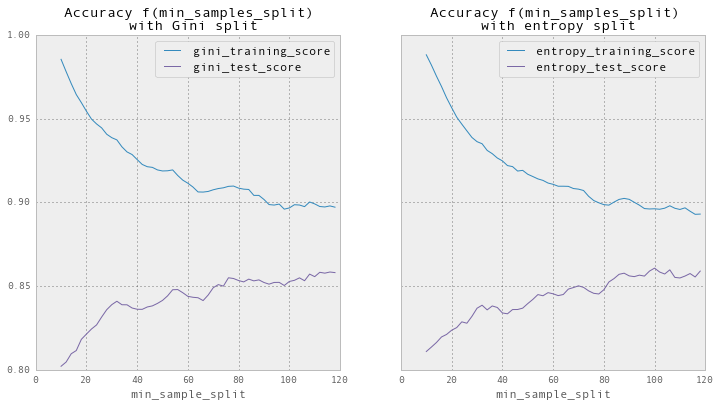

In [8]:
dt.plot_accuracy_function(df, smoothing_factor=5)

__Observation on min_sample_split__:

Given the default setting for minimum number of samples required to split is 2, the classifier was clearly overfitting the data. By tuning the parameter, I was able to increase the test accuracy to above 85% while decreasing accuracy on training dataset.
By visually inspecting the graphs, it can be inferred that the optimal setting for minimum number of samples required to split is around 60, which reduces the complexity of the decision tree greatly.


__Observation on splitting rule__:

Generally, choosing decision-tree splitting criteria can affect the accuracy of the classification; for example entropy based criterion favors features with multiple nominals, and given we have real-valued data, this splitting rule could be too sensitive.  However it does not appear to make a big difference on the higgs dataset.
Both 'gini' and 'entropy' produce similar accuracy trends with hardly detectable slower ramp-up of the entropy for smaller values of min_samples_split.

Additional tuning of the classfier, such as maximum depth of the tree, or minimum number of samples required to be at a leaf node, did not contribute to the accuracy of the predictions, so they were left at default settings.

Below are the final scores achieved by Decision Tree classifier:

In [9]:
dt_trn_acc, dt_tst_acc = dt.run_decision_tree(higgs_data, min_samples_split=60)
print 'Accuracy on training data:', dt_trn_acc
print 'Accuracy on test data', dt_tst_acc

Accuracy on training data: 0.909422374408
Accuracy on test data 0.844064103952


###Neural Networks

Since sklearn does not implement Neural network, in this analysis I am using pybrain library.

Fully connected Neural Network is constructed with the following specifications:

- input layer - 13 sigmoid neurons

- hidden layer - 19 sigmoid neurons

- output layer - 1 softmax neuron (since output should be binarized)

- training algorithm - backpropagation

In [10]:
from algo_evaluation.algos import neural_network as nn

In [11]:
nn_df = nn.estimate_training_iterations(n_iterations=20)

I have run the experiment for up to 500 iterations (only 20 iterations shown here due to runtime constraints) and unfortunately the network is not learning very well.

Neural Net on Higgs is the most stable with a learning rate of 0.001, where the accuracy curve is not jumping very much.  Demonstrated below are learning curves for 4 settings of learning rates: 0.001, 0.01, 0.1 and 1.0.

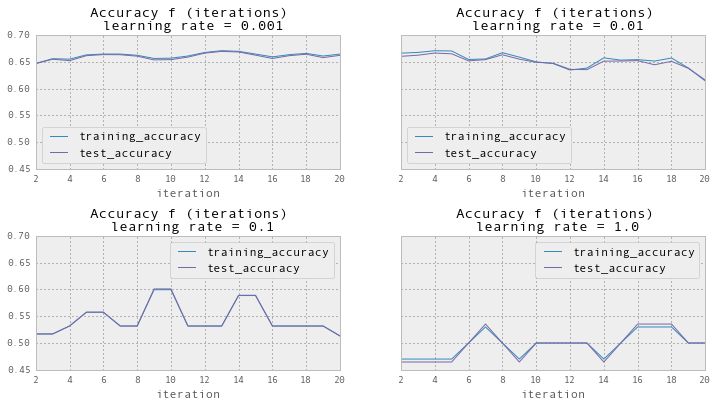

In [12]:
nn_plot = nn.plot_accuracy_function(nn_df, smooth_factor=2)

Final accuracy scores of the Neural Networks classification:

In [13]:
epochs, nn_trn_err, nn_tst_err = nn.run_neural_net(higgs_data)
nn_trn_acc = 1 - nn_trn_err/100
nn_tst_acc = 1 - nn_tst_err/100
print 'Total epochs (iterations) trained', epochs
print 'Accuracy on training data:', nn_trn_acc
print 'Accuracy on test data', nn_tst_acc

Total epochs (iterations) trained 5
Accuracy on training data: 0.46698950413
Accuracy on test data 0.470792365529


Due to poor results, I have concluded that Neural Networks is not the best algorithm for detecting Higgs.

###AdaBoost

AdaBoost is an example of the ensemble classifier, where a collection of weak learners are combined to produce a meta estimator.

Sklearn python library is using DecisionTrees as the base estimator, so I should be able to get at least the same accuracy as found during Decision Tree evaluation.

Striving to increase the performance above my benchmark, I tuned two parameters:

- maximum number of estimators at which boosting is terminated

- learning rate which shrinks the contribution of each classifier

In [14]:
from algo_evaluation.algos import adaboost as ab

Accuracy functions plotted below showed the expected behavior of the classifier.

- increasing number of estimators is positively correlated with the accuracy; the optimal number n_estimators ~ 100 did not however improve the accuracy of what I was already getting with Decision Trees

- ensemble classifier was able to learn better when contributions from each local classifier were considered equally important (learning_rate ~ 1.0; learning rate below 0.1 leads to very poor results)

In [15]:
estimator_df = ab.estimate_best_n_estimators()
learning_rate_df = ab.estimate_best_learning_rate()

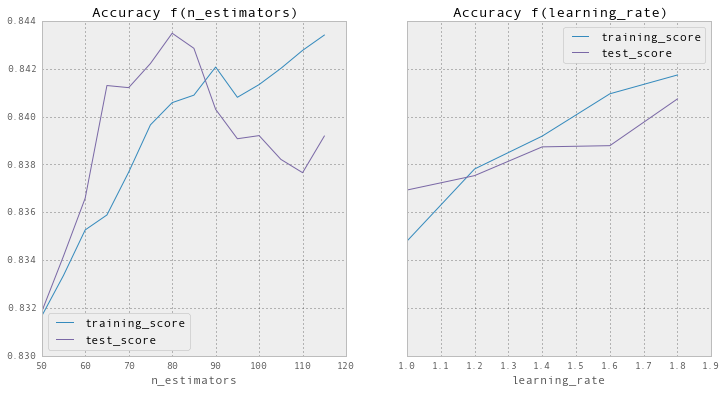

In [40]:
ab.plot_accuracy_functions(estimator_df, learning_rate_df, smoothing_factor=5)

The most surprising effect I have observed with the ensemble classifier is the dynamics of accuracy function depending on the number of estimators.  At some point, above 80, accuracy drops on the training set while continuing to grow on the test set.

Below are the final scores achieved by AdaBoost classifier:

In [17]:
ab_trn_acc, ab_tst_acc = ab.run_AdaBoost(higgs_data, n_estimators=85, learning_rate=1.0)
print 'Accuracy on training data:', ab_trn_acc
print 'Accuracy on test data', ab_tst_acc

Accuracy on training data: 0.844630908339
Accuracy on test data 0.835518091704


###Support Vector Machines

Support Vector Machines algorithm is very effective in high-dimensional spaces and given that I have selected 13 features so far for the Higgs dataset, SVM is expected to work very well.  From my pre-analysis of the data, linear separability was out of the question, so it is important to choose a good non-linear kernel.

Default kernel is `rbf` and upon training on the dataset it classified every single example correctly (more on this phenomenon in the conclusion section).

In [18]:
from algo_evaluation.algos import svm

In [19]:
svm_trn_acc, svm_tst_acc = svm.run_svm(higgs_data, regularization_term=1.0, gamma=0.0)
print 'Accuracy on training data:', svm_trn_acc
print 'Accuracy on test data', svm_tst_acc

Accuracy on training data: 1.0 
Accuracy on test data: 0.996046097547


Even though the accuracy is perfect, I performed multiple experiments tuning:

- regularization parameters 'C': [1, 10, 100, 1000]
- gamma 'gamma': [1e-3, 1e-4]
- kernel: rbf

Using grid search with python library, none of the parameters combinations gave better results, so there isn't anything interesting to plot here.

###K-Nearest Neighbors

K-Nearest Neighbors is an example of the instance-based classification where instead of learning the predictive function, all examples are stored and considered, and when the new event is encountered a set of similar events is used for classification. 

Given this intuition behind the classifier, KNN is the best suited for classifying Higgs particle. To detect signal from background, we do not need to look at the whole data, but rather similar decaying events. The main question to answer here - how many such events should we look for.

The accuracy curve below, given as a function of the number of neigbors, suggests 10 to be an optimal number which generalizes the dataset pretty well.

Additionally, KNN in theory classifies examples very different depending on the distance metric used.  However in the current dataset, metric did not alter accuracy very much and so default can be used. 

Final estimation was using euclidian distance metric and produced the following results:

In [20]:
from algo_evaluation.algos import knn
knn_df = knn.estimate_best_n_neighbours()
p_df = knn.estimate_best_power()

In [24]:
knn_trn_acc, knn_tst_acc = knn.run_knn(higgs_data, n_neighbours=10)
print 'Accuracy on training data:', knn_trn_acc
print 'Accuracy on test data', knn_tst_acc

Accuracy on training data: 0.8846735875
Accuracy on test data 0.860250244311


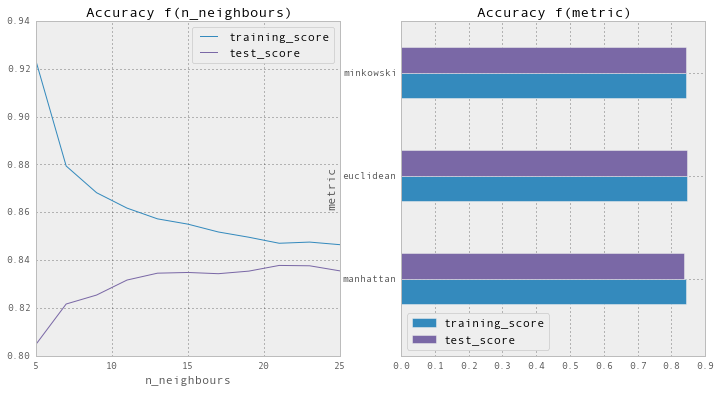

In [23]:
knn_plot = knn.plot_accuracy_function(knn_df, p_df, smoothing_factor=3)

Aggregate all accuracy scores observed on the Higgs dataset for further constrast with Converters dataset:

In [25]:
higgs_scores = [[dt_trn_acc, nn_trn_acc, ab_trn_acc, knn_trn_acc, svm_trn_acc], 
               [dt_tst_acc, nn_tst_acc, ab_tst_acc, knn_tst_acc, svm_tst_acc]]

## Bidding Classification

This classification problem couldn't be more different than Higgs classification and there is great constrast in the field (physics vs. programmatic marketing), data structure (categorical vs. real-valued features), sample and concept complexity (correlation between concept and features is stronger in the converters dataset)

In the interest of space, only final scores are recorded for converters dataset across all algorithms.

In [26]:
dt_trn_acc, dt_tst_acc = dt.run_decision_tree(bid_data)
print 'Accuracy on training data:', dt_trn_acc
print 'Accuracy on test data', dt_tst_acc

Accuracy on training data: 0.969515178043
Accuracy on test data 0.96246929068


In [27]:
iterations, nn_trn_err, nn_tst_err = nn.run_neural_net(bid_data)
nn_trn_acc = 1 - nn_trn_err/100
nn_tst_acc = 1 - nn_tst_err/100
print 'Accuracy on training data:', nn_trn_acc
print 'Accuracy on test data', nn_tst_acc

Accuracy on training data: 1.0
Accuracy on test data 1.0


In [28]:
ab_trn_acc, ab_tst_acc = ab.run_AdaBoost(bid_data)
print 'Accuracy on training data:', ab_trn_acc
print 'Accuracy on test data', ab_tst_acc

Accuracy on training data: 0.941785318881
Accuracy on test data 0.942815325911


In [29]:
knn_trn_acc, knn_tst_acc = knn.run_knn(bid_data)
print 'Accuracy on training data:', knn_trn_acc
print 'Accuracy on test data', knn_tst_acc

Accuracy on training data: 0.943484641726
Accuracy on test data 0.94532434269


In [30]:
svm_trn_acc, svm_tst_acc = svm.run_svm(bid_data)
print 'Accuracy on training data:', svm_trn_acc
print 'Accuracy on test data', svm_tst_acc

Accuracy on training data: 0.994953526095
Accuracy on test data 0.955726308086


In [31]:
bid_scores = [[dt_trn_acc, nn_trn_acc, ab_trn_acc, knn_trn_acc, svm_trn_acc],
               [dt_tst_acc, nn_tst_acc, ab_tst_acc, knn_tst_acc, svm_tst_acc]]

Every single algorithm performed very well on the converters dataset with minimal effort as compared to the large number of experiments and tuning for Higgs detection.  This supports the conjecture of the strong existing correlation between users profiles and their preference for conversion.  This behavior is relatively easily learned for bid and creative placement optimization.

## Performance Comparison

After classifying Higgs particle with presented algorithms, it is very interesting to compare the accuracy scores on both training and test data.

- Accuracy across three algorithms - Decision Tree, AdaBoost, and KNN - is comparable and around 85%.

- SVM algorithm exceeded expecations right "out-of-the-box".  Having an accuracy of 99% on test data is extremely high. This is large due to __highly repetitive__ nature of the particle decays

- Neural Network, on the other hand, produced very low accuracy regardless of tuning and number of iterations.  Another drawback of this algorithm is that it took a very long time to train. Creating larger network could potentially help the accuracy, however the sample size is not sufficient for that.

Aggreggate of all scores and their comparison is shown in the table below:

In [32]:
scores = higgs_scores + bid_scores
algorithms = ['decision_tree', 'neural_network', 'adaboost', 'svm', 'knn']
scores = pd.DataFrame.from_records(scores, columns=algorithms, 
                                   index=['higgs_train', 'higgs_test',
                                          'bids_train', 'bids_test'])
scores

,decision_tree,neural_network,adaboost,svm,knn
higgs_train,0.909422,0.466990,0.844631,0.884674,1.000000
higgs_test,0.844064,0.470792,0.835518,0.860250,0.996046
bids_train,0.969515,1.000000,0.941785,0.943485,0.994954
bids_test,0.962469,1.000000,0.942815,0.945324,0.955726


Notice that accuracy on the second classification problem (converters) is higher than for Higgs detection which should not come as a surprise given complexity of the latter problem.

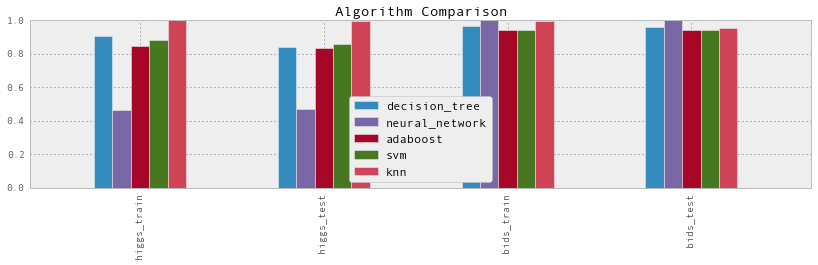

In [33]:
comparison = scores.plot(kind='bar', figsize=(14, 3), title='Algorithm Accuracy Comparison')

__Why Higgs detection showed lower accuracy than converter's classificaton__:

Generally, Higgs particle detection is a very difficult machine learning task, but what the above analysis shows is that even hard problems like this can be tackled using common supervised algorithms (_common_ in the sense that there is no need to invent more complex algorithms).  Having sufficient amount of particle collision records, almost all algorithms showed good accuracy.

Better accuracy and generalization could be achieved by having more domain knowledge in particle physics, for example during feature aggregation and parameters fine-tuning. 

__Higgs Detection Learning Curves__

_To be consistent with the above analysis I am using accuracy metric as it essentially caries the same information as error metric_ 

So far, the analysis of the accuracy was demonstrated as a function of tuning various algorithm parameters (learning rates, regularization parameters, number of estimators, neighbors, etc). In this section I am looking at the learning curves as a function of the sample size change (number of examples in the dataset).

What this analysis is attempting to answer is __how many events__ of particle collisions do I need to be able to detect Higgs signal with the best possible accuracy.

Interesting to note:
- AdaBoost:  test accuracy eventually converges with the accuracy on training data which demonstrates that ensemble classifier in this case does not overfit; 
- SVM:  test accuracy curve is not visible on the graph as it coincided with the training curve and, regardless of the sample size, classifier was able to perfectly learn the concept of the signal (in practice with real data this is nearly impossible to achieve)

Following reductions were made based on the experiment observations (saved experiment running time):

- initial 20 iterations of cross validation were reduced to 5, as learning curve did not have a large variance (padded areas in the graphs);
- initial model evaluations were performed on the full dataset (60k) and eventually reduced to 30k as learning curve plateaued and no significant improvement could be achieved by adding more records.

In [34]:
from algo_evaluation.plotting.plot_learning_curves import plot_learning_curves

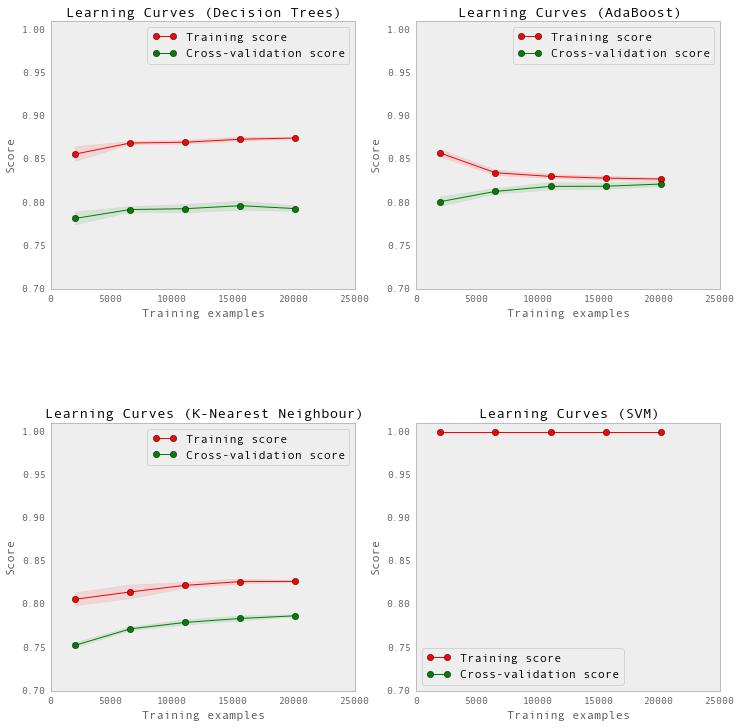

In [35]:
higgs_learning_curve = plot_learning_curves(higgs_data, limit_size=30000)

__Converters Learning Curves__

Same accuracy trends are observed with converters data, where number of records could be reduced to an even lower count (20k) after which accuracy plateaus.

Learning curves for converters dataset provided more insight to differences between algorithms and between classification problems:

- Decision Trees:  After 20k served impressions, accuracy curve stabilized, and comparing to the first classification problem (Higgs detection) better generalization was achieved (smaller gap between test and train accuracy curves) 
- AdaBoost:  Accuracy has large variance on a dataset up to 10k impressions, after which training and testing curves perfectly converged, which means that 10k is the minimum sample size to make a good prediction of users' converting behavior (collecting this required amount of data is easily achieved in practice)
- KNN and SVM showed relatively steady accuracy without much dependence of sample size

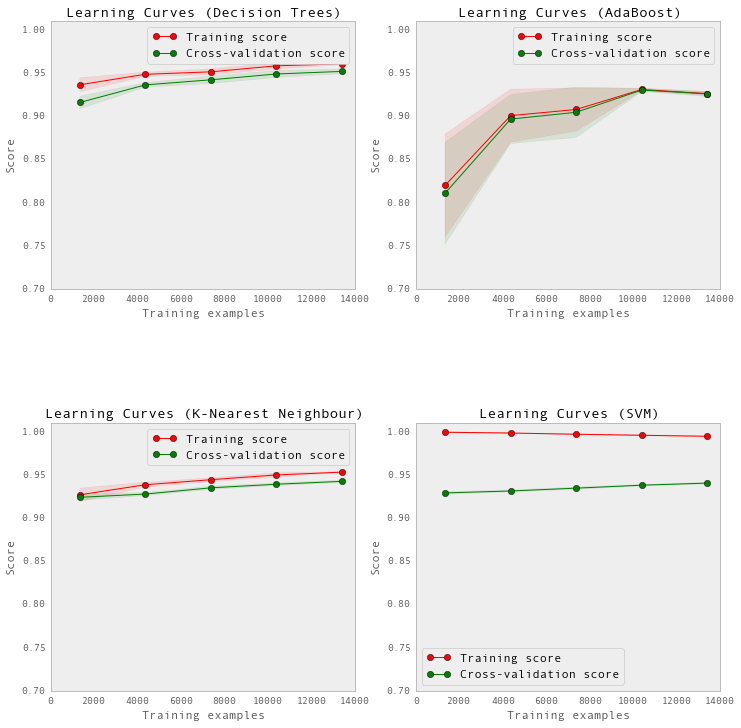

In [36]:
bid_learning_curve = plot_learning_curves(bid_data, limit_size=20000)

##Acknowledgement

Following python libraries were used for the evaluation of algorithms:

- scikit-learn (SVM, AdaBoost, KNN, Decision Tree, Accuracy and Error evaluation) and pybrain (Neural Network)
- pandas (data analysis), numpy (data wrangling) and matplotlib (plotting)

##References

[1] Higgs Boson Machine Learning Challenge: https://www.kaggle.com/c/higgs-boson.

[2] Learning to discover: the Higgs boson machine learning challenge: http://higgsml.lal.in2p3.fr/files/2014/04/documentation_v1.8.pdf.

[3] Support Vector Machines in Analysis of Top Quark Production: http://arxiv.org/abs/hep-ex/0205069.

[4] Stephen Marsland. Machine Learning: An Algorithmic Perspective. CRC Press, 2009.